### Imports

In [35]:
import modin.pandas as md
import statsmodels as sm
import os
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
import sys
sys.path.append('../library')

import itertools

from midStats import *
from core import *
from plotting import *

colorPalette = loadPalette()

### Load Data

In [36]:
dataFiles = [f for f in os.listdir('../data/') if 'movieDetails' in f]
dfs = [md.read_csv(os.path.join('../data/', f)) for f in dataFiles]
df = md.concat(dfs, ignore_index=True)
df.drop_duplicates(inplace=True, keep='last')

### Global Vars

In [37]:
colsOfInterest = ['runtime', 'revenue', 'budget']
plotWidth = 600
plotHeight = 600

### Remove Outliers & Missing Data

In [38]:
df = df[df['budget'] > 0]
df = df[df['revenue'] > 0]
df = df[df['runtime'] > 0]

In [39]:
numCols = df.select_dtypes(include = ['number']).columns

for col in colsOfInterest:
    df[col] = dropNumericalOutliers(x = df[col], low = .01, high = .99)

df.dropna(subset=colsOfInterest, how='any', inplace=True)

### Describe Data

In [40]:
df[colsOfInterest].describe()

,runtime,revenue,budget
count,7449.000000,7.449000e+03,7.449000e+03
mean,107.723856,5.236473e+07,2.109420e+07
std,19.380258,9.314126e+07,2.792187e+07
min,72.000000,1.361000e+03,3.000000e+03
25%,94.000000,3.000000e+06,3.000000e+06
50%,104.000000,1.471179e+07,1.000000e+07
75%,118.000000,5.549556e+07,2.700000e+07
max,181.000000,7.098275e+08,1.750000e+08


#### Show Distributions

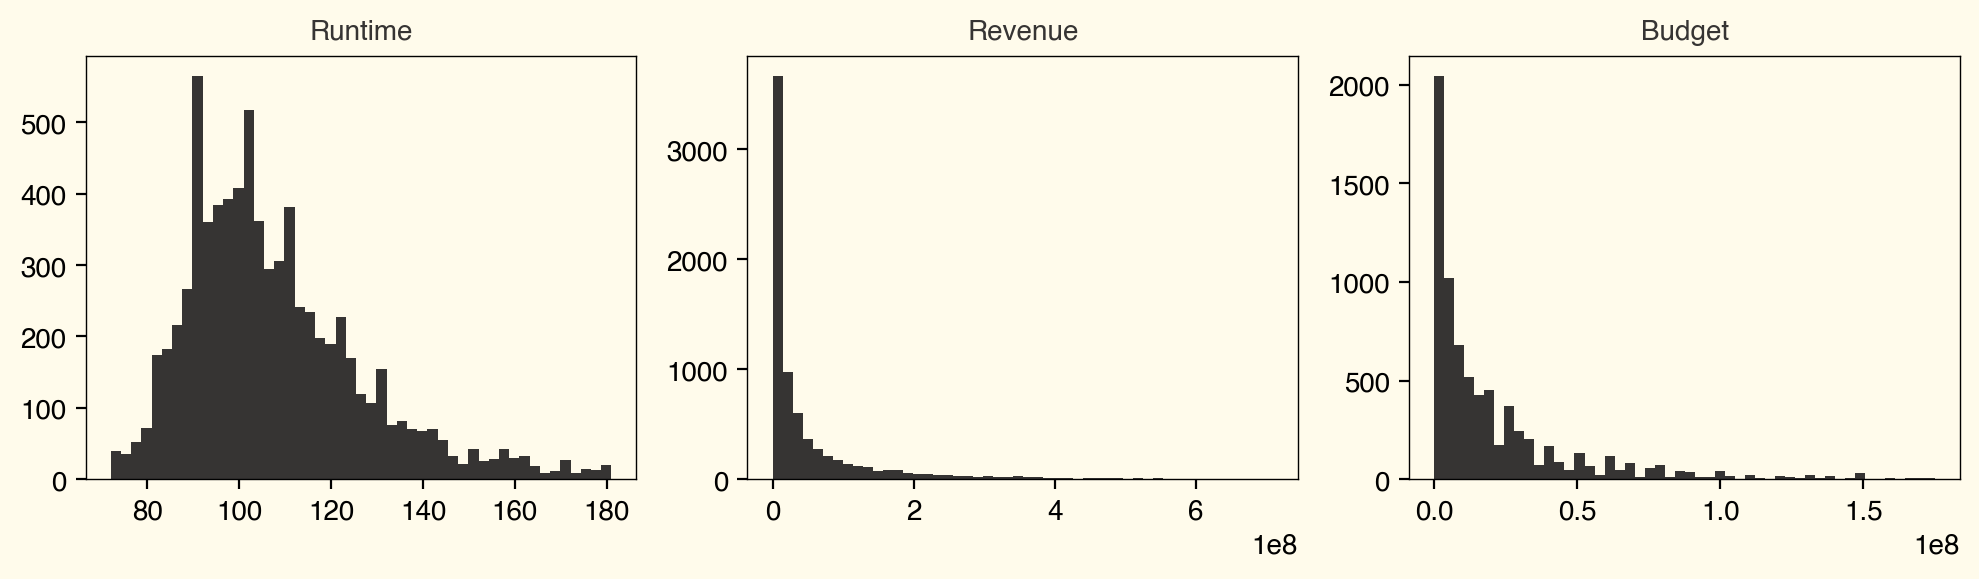

In [46]:
plt.style.use("../assets/plot_styles.mplstyle")

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))

# Iterate over the columns of interest and add histograms to subplots
for i, col in enumerate(colsOfInterest):
    # Check the range of the data
    min_val = df[col].min()
    max_val = df[col].max()
    
    # Calculate bin size
    bin_size = (max_val - min_val) / 50  # Example: 20 bins
    
    # Plot histogram
    axes[i].hist(df[col], bins=int((max_val - min_val) / bin_size))
    axes[i].set_title(f"{titleify(col)}")

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()

#### Basic linear modelling

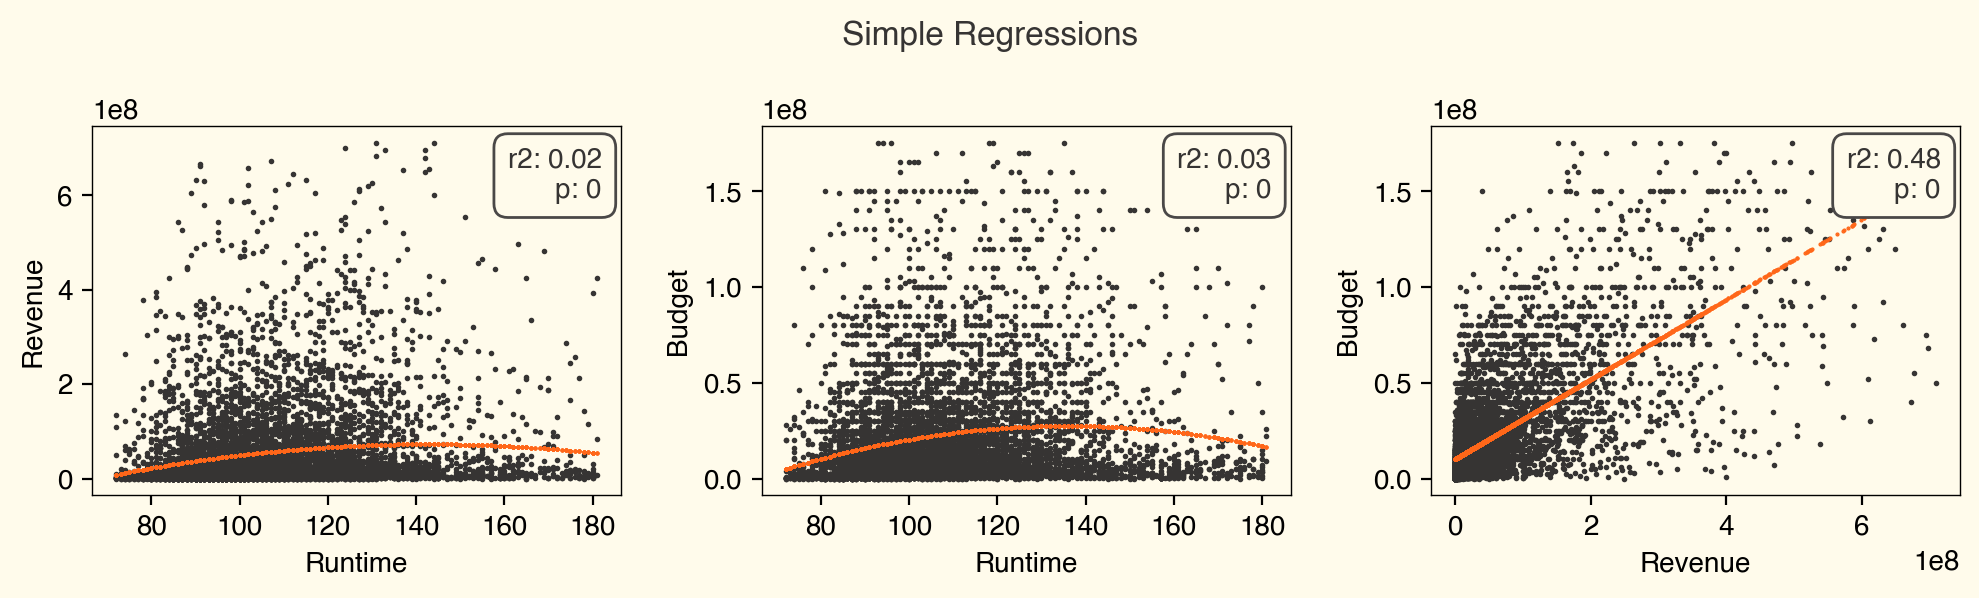

In [49]:
combos = list(itertools.combinations(colsOfInterest, 2))

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))
for i, combo in enumerate(combos):
    xVar = combo[0]
    yVar = combo[1]
    
    model = linearModelGeneral(np.array(df[xVar]), np.array(df[yVar]), [1,2])

    axes[i].scatter(df[xVar], df[yVar], s = 1)
    axes[i].scatter(model['X'], model['ypred'], marker='.', s=1, c=colorPalette['annotation'])
    
    axes[i].set_xlabel(titleify(xVar))
    axes[i].set_ylabel(titleify(yVar))

    annotation_text = f"r2: {round(model['r2'], 2)}\np: {round(model['p'])}"
    axes[i].annotate(annotation_text, xy=(.99, .98), xycoords='axes fraction', fontsize=10,
                    xytext=(-5, -5), textcoords='offset points',
                    ha='right', va='top',
                    bbox=dict(boxstyle='round,pad=0.5', edgecolor=colorPalette['grey_light'], facecolor=colorPalette['canvas']))


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Set title
fig.suptitle('Simple Regressions', fontsize=12)

# Show the figure
plt.show()